In [1]:
# import libraries/modules

import pandas as pd
import numpy as np


import tensorflow as tf
import tensorflow_privacy as tfp
from tensorflow_privacy.privacy.optimizers import dp_optimizer_keras
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from transformers import TFBertModel, BertTokenizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import precision_recall_fscore_support, classification_report as sk_classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import math


In [2]:
MAX_LENGTH = 512
EPOCHS = 3
BATCH_SIZE = 32


In [3]:
# load dataset
reviews_df = pd.read_pickle('reviews.pkl')

In [4]:
display(reviews_df)

,user_id,business_id,rating,review,date
0,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
...,...,...,...,...,...
195,pR4DDFXqNylSNAcmTaPMyQ,hRHhP3fhMy3LktPyQa3s_A,3.0,We ran in for a late night dinner last night. ...,2018-01-21 14:07:35
196,nbVYXmDUO6XH-wvhY62uvg,XMGjDIAFbu9VSmWDs-Ev5w,4.0,Stopped by to munch a burger during today's Se...,2011-01-08 23:52:22
197,YRFeRq--jTV6G3HMgesSEg,wqj6JquckEOs1h7rs376kQ,4.0,I can only comment on the vermicelli bowls bec...,2013-01-27 18:10:56
198,6M7PMBWbBcp5VZ84AY3EFA,mLNSOU8Ki0Fm09xd6ZKkcA,2.0,I had the Chicken Marsala recommended by our w...,2015-01-18 19:04:28


In [5]:
# Label encode forms
# Initialize LabelEncoder
le = LabelEncoder()

# Fit and transform the column
reviews_df['rating_encoded'] = le.fit_transform(reviews_df['rating'])

# Split data into training, validation, and test sets
x_train, x_val, y_train, y_val = train_test_split(reviews_df['review'], reviews_df['rating_encoded'], test_size=0.40, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(reviews_df['review'], reviews_df['rating_encoded'], test_size=0.50, random_state=1234)

# apply one-hot encoding to labels
y_train_one_hot = tf.one_hot(y_train, depth=5)
y_val_one_hot = tf.one_hot(y_val, depth=5)
y_test_one_hot = tf.one_hot(y_test, depth=5)

2025-03-30 14:55:39.101836: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-03-30 14:55:39.101856: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-03-30 14:55:39.101860: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-03-30 14:55:39.101883: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-30 14:55:39.101898: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
# compute class weights
def compute_class_weights(labels):
    # Calculate class weights to correct for class imbalance
    weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    label_weights = dict(enumerate(weights))

    return label_weights

CLASS_WEIGHTS = compute_class_weights(y_train_one_hot.numpy().argmax(axis=1))
print(CLASS_WEIGHTS)

# Calculate delta based on the number of training examples
n_examples = len(x_train[0])  # Number of training examples
DELTA = min(1e-5, 1.0 / (10 * n_examples))

{0: 3.0, 1: 3.4285714285714284, 2: 1.6, 3: 0.9230769230769231, 4: 0.375}


In [7]:
# Create bert encoder function
def bert_encode(texts, tokenizer, max_len=MAX_LENGTH, min_word_freq=1):
    # Convert texts to strings
    texts_str = [str(text) for text in texts]

    # Count word frequencies
    word_freq = {}
    for text in texts_str:
        for word in text.split():
            word_freq[word] = word_freq.get(word, 0) + 1

    # Filter rare words
    filtered_texts = []
    for text in texts_str:
        words = text.split()
        filtered_words = [word if word_freq[word] >= min_word_freq else '[UNK]' for word in words]
        filtered_texts.append(' '.join(filtered_words))

    # Tokenize filtered texts
    tokenized = tokenizer(filtered_texts,
                         max_length=max_len,
                         truncation=True,
                         padding='max_length',
                         return_tensors='tf')

    return tokenized

# select tokenizer
def select_tokenizer(pretrained):
    tokenizers = {
        'bert-base-cased': BertTokenizer.from_pretrained(pretrained),
        'bert-base-uncased': BertTokenizer.from_pretrained(pretrained),
        'nlptown/bert-base-multilingual-uncased-sentiment': BertTokenizer.from_pretrained(pretrained)
    }
    tokenizer = tokenizers[pretrained]
    return tokenizer

In [8]:
# Select pretrained
model_checkpoint = 'nlptown/bert-base-multilingual-uncased-sentiment'

# Load tokenizer
bert_tokenizer = select_tokenizer(model_checkpoint)

# Tokenize dataset
train_encodings = bert_encode(x_train, bert_tokenizer)
train_labels = np.array(y_train_one_hot)
val_encodings = bert_encode(x_val, bert_tokenizer)
val_labels = np.array(y_val_one_hot)
test_encodings = bert_encode(x_test, bert_tokenizer)
test_labels = np.array(y_test_one_hot)


## Model with Differential Privacy Integration

In [9]:
def build_dp_model(bert_base,
                trainable=True,
                max_length=MAX_LENGTH,
                num_classes=5,
                hidden_size=256,
                dropout=0.3,
                learning_rate=0.00005,
                epsilon=None,
                delta=DELTA): 

    bert_model = TFBertModel.from_pretrained(bert_base)
    bert_model.bert.embeddings.trainable = False
    bert_model.trainable = trainable

    input_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name='input_ids_layer')
    token_type_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_output = bert_model(bert_inputs)
    pooler_output = bert_output[1]
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_output)
    dropout_layer = tf.keras.layers.Dropout(dropout)(hidden)
    class_output = tf.keras.layers.Dense(num_classes, activation='softmax', name="classification_layer")(dropout_layer)

    model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=class_output)

    if epsilon is not None:
        # Calculate noise multiplier, σ = sqrt(2*log(1.25/δ))/ε
        noise_multiplier = math.sqrt(2 * math.log(1.25/delta)) / epsilon
        
        l2_norm_clip = 1.0
        
        optimizer = dp_optimizer_keras.DPKerasAdamOptimizer(
            l2_norm_clip=l2_norm_clip,
            noise_multiplier=noise_multiplier,
            num_microbatches=1,
            learning_rate=learning_rate
        )
        
        print(f"DP enabled with epsilon={epsilon}, noise multiplier={noise_multiplier}")
    else:
        # Standard optimizer (no privacy)
        optimizer = Adam(learning_rate=learning_rate, clipnorm=1.0) 
        print("No privacy protection applied")
    
    # Compile the model once with the chosen optimizer
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    
    return model

# Obtain instance of pretrained model
dp_model = build_dp_model(model_checkpoint)
dp_model.summary()

Some layers from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment were not used when initializing TFBertModel: ['dropout_37', 'classifier']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


No privacy protection applied
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 512)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                        

## Experiments


In [10]:
# Run experiments with different privacy budgets
def run_dp_experiments(x_train, y_train, x_val, y_val, x_test, y_test, epsilons=[None]):
    results = []
    train_inputs = [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask]
    val_inputs = [x_val.input_ids, x_val.token_type_ids, x_val.attention_mask]
    test_inputs = [x_test.input_ids, x_test.token_type_ids, x_test.attention_mask]
    
    for epsilon in epsilons:
        print(f"\n{'=' * 50}")
        print(f"Training with epsilon = {epsilon if epsilon is not None else 'No DP'}")
        print(f"{'=' * 50}")
        
        # Build model with specified privacy budget
        model = build_dp_model('nlptown/bert-base-multilingual-uncased-sentiment', epsilon=epsilon)
        
        # Train model
        history = model.fit(
            train_inputs, 
            y_train,
            validation_data=(val_inputs, y_val),
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            class_weight=CLASS_WEIGHTS,
            verbose=1
        )
        
        # Evaluate on test set
        test_loss, test_acc, test_precision, test_recall = model.evaluate(test_inputs, y_test, verbose=0)
        
        # Get predictions and calculate F1 score
        y_pred = np.argmax(model.predict(test_inputs), axis=1)
        y_true = np.argmax(y_test, axis=1)
        f1 = f1_score(y_true, y_pred, average='weighted')
        
        # Store results
        results.append({
            'epsilon': epsilon,
            'accuracy': test_acc,
            'precision': test_precision,
            'recall': test_recall,
            'f1_score': f1,
            'val_accuracy': max(history.history['val_accuracy']),
            'training_history': history.history
        })
        
        print(f"Test results for epsilon={epsilon if epsilon is not None else 'No DP'}:")
        print(f"Accuracy: {test_acc:.4f}")
        print(f"Precision: {test_precision:.4f}")
        print(f"Recall: {test_recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        
    return results

# Plot results to visualize privacy-utility tradeoff
def plot_privacy_utility_tradeoff(results):
    # Convert None to "No DP" for plotting
    epsilon_labels = ["No DP" if r['epsilon'] is None else str(r['epsilon']) for r in results]
    accuracies = [r['accuracy'] for r in results]
    f1_scores = [r['f1_score'] for r in results]
    
    plt.figure(figsize=(12, 8))
    
    # Plot privacy-utility tradeoff
    plt.subplot(2, 1, 1)
    plt.plot(epsilon_labels, accuracies, 'o-', label='Accuracy')
    plt.plot(epsilon_labels, f1_scores, 'd-', label='F1 Score')
    plt.title('Privacy-Utility Tradeoff')
    plt.xlabel('Privacy Budget (ε)')
    plt.ylabel('Performance Metric')
    plt.grid(True)
    plt.legend()
    
    # Plot training curves for each epsilon
    plt.subplot(2, 1, 2)
    for i, r in enumerate(results):
        if 'training_history' in r and 'val_accuracy' in r['training_history']:
            val_acc = r['training_history']['val_accuracy']
            # Ensure val_acc is a list and contains valid values to plot
            if isinstance(val_acc, list) and len(val_acc) > 0:
                # Get x values (epochs)
                epochs = list(range(1, len(val_acc) + 1))
                label = f"ε={r['epsilon']}" if r['epsilon'] is not None else "No DP"
                plt.plot(epochs, val_acc, marker='o', label=label)
    
    plt.title('Validation Accuracy During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.xticks(np.arange(1, 4))  # Assuming 3 epochs
    plt.ylim(0, 1.0)  # Accuracy is between 0 and 1
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('privacy_utility_tradeoff.png', dpi=300)
    plt.show()
    
    # Create a summary table of performance metrics
    results_df = pd.DataFrame({
        'Epsilon': epsilon_labels,
        'Accuracy': [r['accuracy'] for r in results],
        'F1 Score': [r['f1_score'] for r in results]
    })
    
    return results_df


In [11]:
#Set privacy budgets to test
epsilon_values = [None, 10.0, 5.0, 2.0, 1.0, 0.8, 0.5] 

# Run the experiments
results = run_dp_experiments(train_encodings, train_labels, val_encodings, val_labels, test_encodings, test_labels, epsilons=epsilon_values)



Training with epsilon = No DP


Some layers from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment were not used when initializing TFBertModel: ['dropout_37', 'classifier']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


No privacy protection applied
Epoch 1/3


2025-03-30 14:55:51.841020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-03-30 14:55:52.660664: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_10.


4/4 [==============================] - 53s 10s/step - loss: 1.6773 - accuracy: 0.2250 - precision_1: 0.2857 - recall_1: 0.0333 - val_loss: 0.9495 - val_accuracy: 0.6600 - val_precision_1: 0.9286 - val_recall_1: 0.1300
Epoch 2/3
4/4 [==============================] - 32s 8s/step - loss: 1.1811 - accuracy: 0.6000 - precision_1: 0.7424 - recall_1: 0.4083 - val_loss: 1.0654 - val_accuracy: 0.4500 - val_precision_1: 0.7179 - val_recall_1: 0.2800
Epoch 3/3
4/4 [==============================] - 7s 942ms/step
Test results for epsilon=No DP:
Accuracy: 0.6900
Precision: 0.7917
Recall: 0.5700
F1 Score: 0.6901

Training with epsilon = 10.0


Some layers from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment were not used when initializing TFBertModel: ['dropout_37', 'classifier']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


DP enabled with epsilon=10.0, noise multiplier=0.4844805262605389
Epoch 1/3


4/4 [==============================] - 63s 11s/step - loss: 2.2993 - accuracy: 0.0250 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 2.2556 - val_accuracy: 0.0400 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/3
4/4 [==============================] - 38s 9s/step - loss: 2.1844 - accuracy: 0.0500 - precision_2: 0.0526 - recall_2: 0.0083 - val_loss: 2.2526 - val_accuracy: 0.0400 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/3
4/4 [==============================] - 10s 2s/step
Test results for epsilon=10.0:
Accuracy: 0.0500
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0394

Training with epsilon = 5.0


Some layers from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment were not used when initializing TFBertModel: ['dropout_37', 'classifier']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


DP enabled with epsilon=5.0, noise multiplier=0.9689610525210778
Epoch 1/3


4/4 [==============================] - 87s 15s/step - loss: 1.6760 - accuracy: 0.4417 - precision_3: 0.5588 - recall_3: 0.1583 - val_loss: 1.3302 - val_accuracy: 0.5200 - val_precision_3: 0.6923 - val_recall_3: 0.2700
Epoch 2/3
4/4 [==============================] - 53s 13s/step - loss: 1.6370 - accuracy: 0.4750 - precision_3: 0.6098 - recall_3: 0.2083 - val_loss: 1.3310 - val_accuracy: 0.5200 - val_precision_3: 0.6923 - val_recall_3: 0.2700
Epoch 3/3
4/4 [==============================] - 9s 1s/step
Test results for epsilon=5.0:
Accuracy: 0.5300
Precision: 0.5714
Recall: 0.2000
F1 Score: 0.4144

Training with epsilon = 2.0


Some layers from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment were not used when initializing TFBertModel: ['dropout_37', 'classifier']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


DP enabled with epsilon=2.0, noise multiplier=2.4224026313026945
Epoch 1/3


4/4 [==============================] - 76s 14s/step - loss: 1.6154 - accuracy: 0.3000 - precision_4: 0.4000 - recall_4: 0.0333 - val_loss: 1.4257 - val_accuracy: 0.3100 - val_precision_4: 0.6667 - val_recall_4: 0.0400
Epoch 2/3
4/4 [==============================] - 36s 8s/step - loss: 1.6692 - accuracy: 0.2417 - precision_4: 0.3750 - recall_4: 0.0500 - val_loss: 1.4250 - val_accuracy: 0.3300 - val_precision_4: 0.6667 - val_recall_4: 0.0400
Epoch 3/3
4/4 [==============================] - 9s 1s/step
Test results for epsilon=2.0:
Accuracy: 0.2800
Precision: 0.2000
Recall: 0.0100
F1 Score: 0.2952

Training with epsilon = 1.0


Some layers from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment were not used when initializing TFBertModel: ['dropout_37', 'classifier']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


DP enabled with epsilon=1.0, noise multiplier=4.844805262605389
Epoch 1/3


4/4 [==============================] - 89s 14s/step - loss: 2.0418 - accuracy: 0.1917 - precision_5: 0.2162 - recall_5: 0.0667 - val_loss: 1.9751 - val_accuracy: 0.1200 - val_precision_5: 0.2857 - val_recall_5: 0.0200
Epoch 2/3
4/4 [==============================] - 37s 9s/step - loss: 1.9420 - accuracy: 0.1917 - precision_5: 0.1562 - recall_5: 0.0417 - val_loss: 1.9743 - val_accuracy: 0.1200 - val_precision_5: 0.2857 - val_recall_5: 0.0200
Epoch 3/3
4/4 [==============================] - 9s 1s/step
Test results for epsilon=1.0:
Accuracy: 0.2100
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.1181

Training with epsilon = 0.8


Some layers from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment were not used when initializing TFBertModel: ['dropout_37', 'classifier']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


DP enabled with epsilon=0.8, noise multiplier=6.056006578256736
Epoch 1/3


4/4 [==============================] - 97s 15s/step - loss: 1.4813 - accuracy: 0.2333 - precision_6: 0.2333 - recall_6: 0.0583 - val_loss: 1.5258 - val_accuracy: 0.2500 - val_precision_6: 0.1250 - val_recall_6: 0.0300
Epoch 2/3
4/4 [==============================] - 36s 9s/step - loss: 1.5386 - accuracy: 0.2500 - precision_6: 0.0870 - recall_6: 0.0167 - val_loss: 1.5257 - val_accuracy: 0.2500 - val_precision_6: 0.1250 - val_recall_6: 0.0300
Epoch 3/3
4/4 [==============================] - 13s 2s/step
Test results for epsilon=0.8:
Accuracy: 0.1300
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.1322

Training with epsilon = 0.5


Some layers from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment were not used when initializing TFBertModel: ['dropout_37', 'classifier']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


DP enabled with epsilon=0.5, noise multiplier=9.689610525210778
Epoch 1/3


4/4 [==============================] - 106s 17s/step - loss: 1.5884 - accuracy: 0.2417 - precision_7: 0.2222 - recall_7: 0.0333 - val_loss: 1.6736 - val_accuracy: 0.2700 - val_precision_7: 0.5000 - val_recall_7: 0.0100
Epoch 2/3
4/4 [==============================] - 53s 12s/step - loss: 1.6499 - accuracy: 0.1917 - precision_7: 0.4167 - recall_7: 0.0833 - val_loss: 1.6743 - val_accuracy: 0.2700 - val_precision_7: 0.5000 - val_recall_7: 0.0100
Epoch 3/3
4/4 [==============================] - 12s 2s/step
Test results for epsilon=0.5:
Accuracy: 0.2500
Precision: 0.5000
Recall: 0.0100
F1 Score: 0.1546


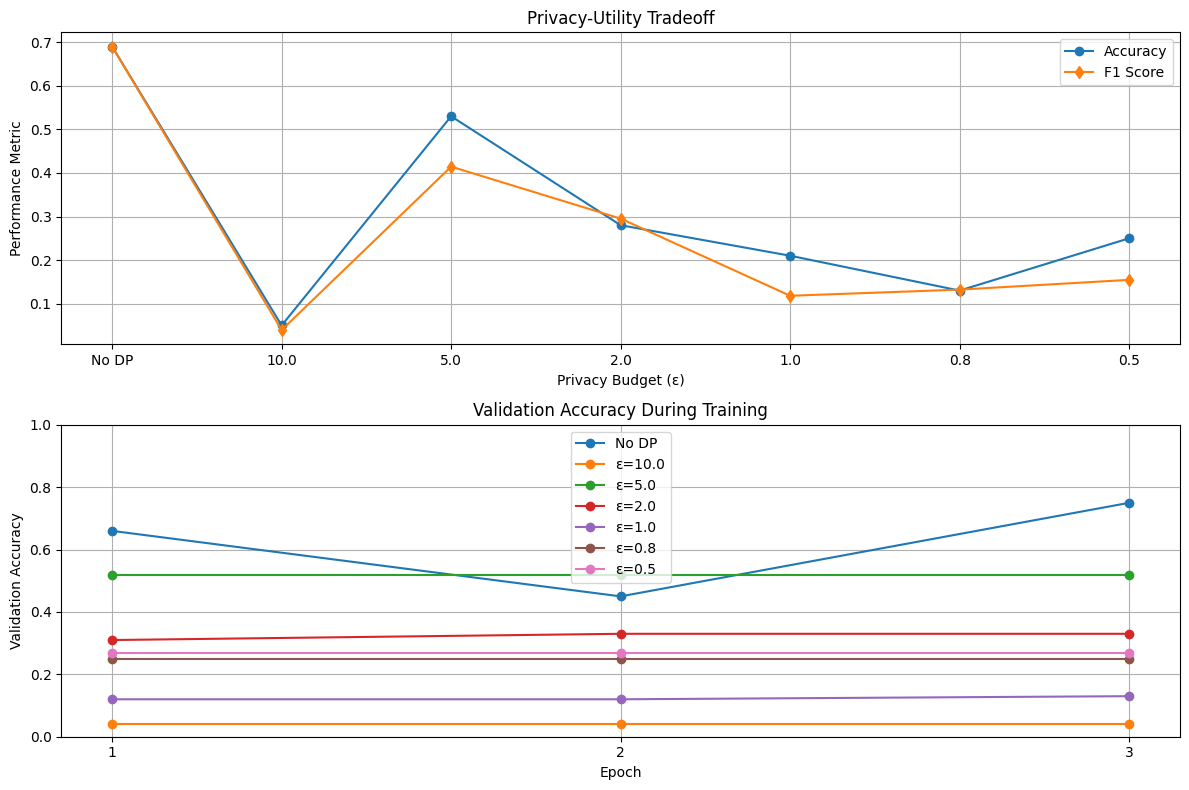

Performance Summary:


,Epsilon,Accuracy,F1 Score
0,No DP,0.69,0.690092
1,10.0,0.05,0.039441
2,5.0,0.53,0.414444
3,2.0,0.28,0.295169
4,1.0,0.21,0.118125
5,0.8,0.13,0.132188
6,0.5,0.25,0.154626


In [12]:
# Plot and analyze results
results_df = plot_privacy_utility_tradeoff(results)
print("Performance Summary:")
display(results_df)


In [13]:
# Save results if needed
# # results_df.to_csv('dp_sentiment_analysis_results.csv', index=False)